### NOTES
This is a configuration of parameters set up to represent a _shallow_ overturning circulation, e.g. in the equatorial Pacific. This is a bit of a hack and should instead be modified more fully in the code, but I figure it is OK for current purposes.

In [1]:
import glob              as gb
import matplotlib        as mp
import matplotlib.pyplot as plt
import numpy             as np
import numpy.ma          as nm
import pandas            as pd
import warnings          as ws


# Some figure options for later
mp.rcParams["xtick.labelsize"] = 14
mp.rcParams["ytick.labelsize"] = 14


def compile_microcosm(options=None):
    # Function to help compile the microCOSM box model
    # Supply compile options as a list of the following:
    #    FIXATMPCO2 - disable the conservative atmospheric carbon box
    #    WRITEOUTFILE - enable the textfile output.
    # NOTE: you have to restart the kernal if you change these options and recompile
    #       more than once...limitation of using f2py
    import os
    import subprocess

    # Depending on platform
    if os.sys.platform == "darwin":
        # Issue with compilation where f2py is linking to v10.9 rather than current OSX version.
        import platform

        mac_ver = ".".join(platform.mac_ver()[0].split(".")[:2])
        env = dict(os.environ, **{"MACOSX_DEPLOYMENT_TARGET": mac_ver})
    else:
        env = os.environ

    optdefs = "OPTIONDEFS = "
    if options is not None:
        optdefs = optdefs + " ".join(["-D" + item for item in options])
        print("Compiling with options: " + optdefs)

    runmake = subprocess.Popen(
        ["make", "pymodel", optdefs],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        text=True,
        env=env,
    )
    runmake.wait()
    print("The exit code for compilations was: %d" % runmake.returncode)
    return runmake.returncode

## 1. Model parameters and initial conditions

<img src="boxmodel_schematic.png" width="350" />

The _microCOSM_ model has three boxes linked by an overturning circulation: an cool, fresh, upwelling box with low iron input analagous to HNLC regions like the Southern Ocean, and a warmer, salty, deep water formation region with significant iron input analagous to the Atlantic Ocean. Iron-binding ligands are produced by organic matter turnover, and lost by microbial degradation (Lauderdale et al, 2020, doi:10.1073/pnas.1917277117).

First, we want to compile the model with the correct flags:

In [2]:
ec = compile_microcosm()#options=["FIXATMPCO2"]

if ec == 0:
    import microCOSM

The exit code for compilations was: 0


Set a few parameters:

In [18]:
# Because f2py is finicky about allocatable output arrays, it is ideal to aim for 1000 output timesteps
# Run for 100kyrs, with 100 year output
maxyears    = 1e5
outputyears = 1e2
outstepmax  = (maxyears/outputyears)+1 # this is the length of the output vectors/arrays

# Apply perturbation to growth rate
palpha = 1

### !!! THESE ARE NOT CALLED ANYWHERE BY THE MODEL !!! ###
# Geometry: Box dimensions (m), areas, volumes
dx = np.array([17.0e6, 17.0e6, 17.0e6])
dy = np.array([ 1.0e6, 3.5e6, 4.5e6])
dz = np.array([100.0,   100.0, 900.0  ])

area  = dx * dy
vol   = area * dz
invol = 1.0 / vol

# Rate of overturning circulation
psi = np.array((10.0e6,))  # Sv

**Surface iron input rate (Atlantic receives 1.00xdep [g/m2/yr] while SO receives 0.01xdep)**

Default value in the model (7.0) is taken from the box model paper (Table 1) in Parekh et al (2004) with a asymetry value of 0.01. Data from Mahowald et al (2006) suggests:\
• Whole NA: 0.25 gFE m-2 yr-1\
• 0 to 20N: 0.40 gFE m-2 yr-1\
• 20N ++  : 0.16 gFE m-2 yr-1\
• 40N ++  : 0.10 gFE m-2 yr-1\
• Whole SO: 0.0015 gFE m-2 yr-1\
• Whole SH: 0.0033 gFE m-2 yr-1


In [19]:
# Elemental stoichiometry
R_np = 16
R_cp = 106

# Biological production maximum rate per year (mol/kg/yr converted to mol/m3/s within the model)
alpha_yr = np.array((6e-6,))
fadd = "equatorial_"

# Iron input to each box (i.e. representing dust, sediment, or hydrothermal fluxes)
# Dust deposition in g Fe m-2 year-1
# Hydrothermal vent input of 1 Gmol/yr (Tagliabue et al., 2010)
# mol Fe/yr * g/mol * 1/area  == g Fe m-2 year-1....
# divide by 2.5e-3 because fe_sol=2.5e-3 is multiplied again within the box model.
fe_input = np.array([0.1, 0.1, (1e9 * 56) / (area[2] * 0.0025)])

# Fixed value for uniform ligand control experiment
fixedligconc = 2.0

if fixedligconc == 0:
    # Assume this means prognostic ligand required
    fadd       = fadd + "variablelt"
    # Gamma over lambda for ligands "optimum" value (Lauderdale et al 2020)
    lig_gaovla = 4398.0

    # gamma input to the model is in phosphate units, not carbon units...
    # (also applies to gamma_over_lambda...lambda should be in 1/seconds)
    lig_gamma  = np.array((5e-5 * R_cp,))
    lig_lambda = 1.0 / ((lig_gamma / R_cp) / lig_gaovla)
else:
    fadd       = fadd + "fixedlt{0:1.0f}nm".format(fixedligconc)
    lig_gamma  = np.array((0.0,))
    lig_lambda = np.array((0.0,))

# Deep ocean box lifetime modifier - capture the gradient introduced by photodegradation near the surface and slower loss in the deep ocean
dlambdadz = np.array([1.0, 1.0, 0.01])

# For air sea exchange of CO2 we need wind speed and the open ocean fraction (ie sea-ice cover or deep ocean)
wind  = np.array([10.0, 5.0, 0.0])
fopen = np.array([ 1.0, 1.0, 0.0])

SPUNUP = False

# Typical concentrations, etc
theta = np.array((20.0, 10.0, 4.0))
salt  = np.array((35.50, 35.50, 34.5))
if SPUNUP is True:
    # Here are some equilibrated initial concentrations in (u/n)mol/kg
    # run for 100,000 yrs (round-off error notwithstanding)
    # Make sure to compile without -DFIXATMPCO2
#     carbon     = np.array((2264.67564, 2103.48757, 2364.66971))
#     alkalinity = np.array((2395.54471, 2387.42965, 2399.11941))
#     phosphate  = np.array((   1.81089,    0.25031,    2.49834))
#     nitrate    = np.array((  25.01353,    0.04412,   36.01262))
#     iron       = np.array((   0.00377,    0.49776,    0.58847))
#     ligand     = np.array((   2.08548,    1.56387,    1.62029))
#     atmpco2    = np.array(( 280.00000,))
    carbon     = np.array((1954.533443, 1995.525096, 2232.336209))
    alkalinity = np.array((2275.797105, 2269.144556, 2280.091013))
    phosphate  = np.array((   1.668467,    0.389130,    2.494218))
    nitrate    = np.array((  26.695468,    6.226085,   39.907491))
    iron       = np.array((   0.003549,    0.002588,    0.766745))
    ligand     = np.array((   2,    2,    2))
    atmpco2    = np.array(( 183.220643,))
else:
    # Here are some typical initial concentrations in (u/n)mol/kg
    # Make sure to compile with -DFIXATMPCO2 first
    carbon     = np.array((2000.0, 2000.0, 2220.0))
    alkalinity = np.array((2280.0, 2280.0, 2280.0))
    phosphate  = np.array((   0.5,    0.0,    2.5))
    nitrate    = np.array((  8.0,    0.0,   40.0))
    iron       = np.array((   0.0,    0.0,    0.0))
    ligand     = np.ones ((3,)) * fixedligconc
    atmpco2    = np.array((280.00000,))

### Create a consolidated Pandas dataframe with the input values to feed into the model

In [20]:
time = pd.DataFrame({
         "niter": int(1),
         "nyrs" : maxyears,
         "tout" : outputyears,
         "nout" : int(outstepmax),
           },index=[0])

parm = pd.DataFrame({
         "psi"       : psi,
         "palpha"    : palpha,
         "alphabio"  : alpha_yr,
         "gamma"     : lig_gamma,
         "lambda"    : lig_lambda,
         "dlambdadz" : [dlambdadz],
         "sourceFe"  : [fe_input],
         "wind"      : [wind],
         "fopen"     : [fopen],
                 })

data = pd.DataFrame({
         "theta"     : [theta],
         "salt"      : [salt],
         "carbon"    : [carbon],
         "alkalinity": [alkalinity],
         "phosphate" : [phosphate],
         "nitrate"   : [nitrate],
         "iron"      : [iron],
         "ligand"    : [ligand],
         "atmpco2"   : atmpco2,
                  })

model_input = pd.concat((time, parm, data), axis=1)
model_input

,niter,nyrs,tout,nout,psi,palpha,alphabio,gamma,lambda,dlambdadz,...,fopen,theta,salt,carbon,alkalinity,phosphate,nitrate,iron,ligand,atmpco2
0,1,100000.0,100.0,1001,10000000.0,1,0.000006,0.0,0.0,"[1.0, 1.0, 0.01]",...,"[1.0, 1.0, 0.0]","[20.0, 10.0, 4.0]","[35.5, 35.5, 34.5]","[2000.0, 2000.0, 2220.0]","[2280.0, 2280.0, 2280.0]","[0.5, 0.0, 2.5]","[8.0, 0.0, 40.0]","[0.0, 0.0, 0.0]","[2.0, 2.0, 2.0]",280.0


### Call the model from the _microCOSM_ package and capture the output in a pandas dataframe 

In [21]:
microCOSM.mod_modelmain.model?

Call signature: microCOSM.mod_modelmain.model(*args, **kwargs)
Type:           fortran
String form:    <fortran object>
Docstring:     
tout,thout,sout,cout,aout,pout,nout,fout,lout,expout,nlout,psout,pco2out,atpco2out = model(id,maxyears,outputyears,outstepmax,psi,palpha,alpha_yr,gamma_fe,lt_lifetime,dlambdadz,fe_input,wind,fopen,thin,sain,cin,ain,pin,nin,fin,lin,atpco2in)

Wrapper for ``model``.

Parameters
----------
id : input int
maxyears : input float
outputyears : input float
outstepmax : input int
psi : input float
palpha : input float
alpha_yr : input float
gamma_fe : input float
lt_lifetime : input float
dlambdadz : input rank-1 array('d') with bounds (3)
fe_input : input rank-1 array('d') with bounds (3)
wind : input rank-1 array('d') with bounds (3)
fopen : input rank-1 array('d') with bounds (3)
thin : input rank-1 array('d') with bounds (3)
sain : input rank-1 array('d') with bounds (3)
cin : input rank-1 array('d') with bounds (3)
ain : input rank-1 array('d') with bound

In [ ]:
timeseries = pd.DataFrame( 
                np.column_stack(
                   microCOSM.mod_modelmain.model(
                          *[model_input[io][0] for io in model_input.columns]
                                                ),
                          ).T,
                   index=[
                          "time",
                          "tso",
                          "tna",
                          "tdo",
                          "sso",
                          "sna",
                          "sdo",
                          "cso",
                          "cna",
                          "cdo",
                          "aso",
                          "ana",
                          "ado",
                          "pso",
                          "pna",
                          "pdo",
                          "nso",
                          "nna",
                          "ndo",
                          "fso",
                          "fna",
                          "fdo",
                          "lso",
                          "lna",
                          "ldo",
                          "exportso",
                          "exportna",
                          "exportdo",
                          "lim",
                          "pstar",
                          "pco2so",
                          "pco2na",
                          "pco2do",
                          "atmpco2",
                      ],
                  ).transpose()

# Save timeseries
# timeseries.to_json("run_microCOSM_" + fadd + "_timeseries.json")

# output array such that it could be used to restart the next simulation
pd.concat(
    [
        time.iloc[0],
        parm.iloc[0],
        pd  .Series({
              "theta"     : timeseries[["tso","tna","tdo"]].iloc[-1].to_numpy(),
              "salt"      : timeseries[["sso","sna","sdo"]].iloc[-1].to_numpy(),
              "carbon"    : timeseries[["cso","cna","cdo"]].iloc[-1].to_numpy(),
              "alkalinity": timeseries[["aso","ana","ado"]].iloc[-1].to_numpy(),
              "phosphate" : timeseries[["pso","pna","pdo"]].iloc[-1].to_numpy(),
              "nitrate"   : timeseries[["nso","nna","ndo"]].iloc[-1].to_numpy(),
              "iron"      : timeseries[["fso","fna","fdo"]].iloc[-1].to_numpy(),
              "ligand"    : timeseries[["lso","lna","ldo"]].iloc[-1].to_numpy(),
              "atmpco2"   : timeseries['atmpco2'].iloc[-1],
                  }),
    ]
).transpose().to_json("run_microCOSM_" + fadd + "_pickup.json")

## 2. Plot the model timeseries

In [ ]:
# Make sure initial conditions are included at t~0
timeseries.at[0, "time"] = 1e-1

# Integrated export production
timeseries["exp"] = timeseries["exportso"] + timeseries["exportna"]

# Plot the timeseries of...
from matplotlib.ticker import FormatStrFormatter

len_xaxis, len_yaxis = 4, 4  # fix here your numbers
xspace, yspace = 0.9, 0.9  # change the size of the void border here.
x_fig, y_fig = len_xaxis / xspace, len_yaxis / yspace

f1, f1ax = plt.subplots(figsize=(3.5 * x_fig, 3.25 * y_fig), ncols=2, nrows=4)
f1.patch.set_facecolor("None")
mycm = plt.cm.get_cmap("viridis")

# ...Carbon and Alkalinity
## SO
f1ax[0, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["cso"],
    color=mycm(240),
    linewidth=5,
    label='"Southern Ocean"',
)
# AO
f1ax[0, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["cna"],
    color=mycm(128),
    linewidth=5,
    label='"Atlantic Ocean"',
)
# DO
f1ax[0, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["cdo"],
    color=mycm(10),
    linewidth=5,
    label="Deep Ocean",
)

f1ax[0, 0].legend(frameon=False, fontsize=14)
f1ax[0, 0].set_ylim(top=np.ceil(np.max(f1ax[0, 0].get_ylim()) / 10) * 10)
# f1ax[0,0].set_xlim(left=-3)
f1ax[0, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 0].set_ylabel("Carbon\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

## SO
f1ax[0, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["aso"],
    color=mycm(240),
    linewidth=5,
    label='"Southern Ocean"',
)
# AO
f1ax[0, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["ana"],
    color=mycm(128),
    linewidth=5,
    label='"Atlantic Ocean"',
)
# DO
f1ax[0, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["ado"],
    color=mycm(10),
    linewidth=5,
    label="Deep Ocean",
)
f1ax[0, 1].legend(frameon=False, fontsize=14)
f1ax[0, 1].set_ylim(top=np.ceil(np.max(f1ax[0, 1].get_ylim()) / 10) * 10)
# f1ax[0,1].set_xlim(left=-3)
f1ax[0, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[0, 1].set_ylabel("Alkalinity\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Macronutrients
# SO
f1ax[1, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["nso"],
    color=mycm(240),
    linewidth=5,
    label='"Southern Ocean"',
)
# AO
f1ax[1, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["nna"],
    color=mycm(128),
    linewidth=5,
    label='"Atlantic Ocean"',
)
# DO
f1ax[1, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["ndo"],
    color=mycm(10),
    linewidth=5,
    label="Deep Ocean",
)
f1ax[1, 0].set_ylim(top=np.ceil(np.max(f1ax[1, 0].get_ylim()) / 10) * 10)
f1ax[1, 0].legend(frameon=False, fontsize=14)
# f1ax[1,0].set_xlim(left=-3)
f1ax[1, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 0].set_ylabel("Nitrate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# SO
f1ax[1, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["pso"],
    color=mycm(240),
    linewidth=5,
    label='"Southern Ocean"',
)
# AO
f1ax[1, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["pna"],
    color=mycm(128),
    linewidth=5,
    label='"Atlantic Ocean"',
)
# DO
f1ax[1, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["pdo"],
    color=mycm(10),
    linewidth=5,
    label="Deep Ocean",
)
f1ax[1, 1].legend(frameon=False, fontsize=14)
# f1ax2.set_ylim(top=3)
f1ax[1, 1].set_xlim(left=-3)
f1ax[1, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[1, 1].set_ylabel("Phosphate\nConcentration\n[$\mu$mol kg$^{-1}$]", fontsize=14)

# ...Iron/Ligands
# SO
f1ax[2, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["fso"],
    color=mycm(240),
    linewidth=5,
    label='"Southern Ocean"',
)
# AO
f1ax[2, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["fna"],
    color=mycm(128),
    linewidth=5,
    label='"Atlantic Ocean"',
)
# DO
f1ax[2, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["fdo"],
    color=mycm(10),
    linewidth=5,
    label="Deep Ocean",
)
f1ax[2, 0].legend(frameon=False, fontsize=14)
f1ax[2, 0].set_ylim(top=np.ceil(np.max(f1ax[2, 0].get_ylim())))
# f1ax[2,0].set_xlim(left=-3)
f1ax[2, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 0].set_ylabel("Iron\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

# SO
f1ax[2, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["lso"],
    color=mycm(240),
    linewidth=5,
    label='"Southern Ocean"',
)
# AO
f1ax[2, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["lna"],
    color=mycm(128),
    linewidth=5,
    label='"Atlantic Ocean"',
)
# DO
f1ax[2, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["ldo"],
    color=mycm(10),
    linewidth=5,
    label="Deep Ocean",
)
f1ax[2, 1].legend(frameon=False, fontsize=14)
f1ax[2, 1].set_ylim(top=np.ceil(np.max(f1ax[2, 1].get_ylim())))
# f1ax[2,1].set_xlim(left=-3)
f1ax[2, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[2, 1].set_ylabel("Ligand\nConcentration\n[nmol kg$^{-1}$]", fontsize=14)

# ...Export/pstar
# Total
f1ax[3, 0].plot(
    np.log10(timeseries["time"]),
    timeseries["exp"],
    color="firebrick",
    linewidth=5,
    label="Export",
)

# PS
f1ax30b = f1ax[3, 0].twinx()
f1ax30b.plot(
    np.log10(timeseries["time"]),
    timeseries["pstar"],
    color="lime",
    linewidth=5,
    label="P*",
)
f1ax[3, 0].legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.3),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax30b.legend(
    loc="upper left",
    bbox_to_anchor=(0.125, 0.28),
    bbox_transform=f1.transFigure,
    frameon=False,
    fontsize=14,
)
f1ax[3, 0].set_ylim(top=np.ceil(np.max(f1ax[3, 0].get_ylim())))
# f1ax[3,0].set_xlim(left=-3)
f1ax[3, 0].yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 0].set_ylabel("Export production\n[GtCy$^{-1}$]", fontsize=14)
f1ax30b.set_ylabel("Efficiency [%]", fontsize=14)
f1ax[3, 0].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

# ...pCO2
# SO
f1ax[3, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["pco2so"],
    color=mycm(240),
    linewidth=5,
    label='"Southern Ocean"',
)
# AO
f1ax[3, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["pco2na"],
    color=mycm(128),
    linewidth=5,
    label='"Atlantic Ocean"',
)
# ATM
f1ax[3, 1].plot(
    np.log10(timeseries["time"]),
    timeseries["atmpco2"],
    color=mycm(10),
    linewidth=5,
    label="Atmosphere",
)
f1ax[3, 1].legend(frameon=False, fontsize=14)
f1ax[3, 1].set_ylim(top=np.ceil(np.max(f1ax[3, 1].get_ylim())))
# f1ax[3,1].set_xlim(left=-3)
f1ax[3, 1].xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
f1ax[3, 1].set_ylabel("Surface Ocean and\nAtm pCO$_2$ [$\mu$atm]", fontsize=14)
f1ax[3, 1].set_xlabel("Model time [log$_{10}$(yrs)]", fontsize=14)

plt.suptitle("microCOSM model output", fontsize=16)
# Can adjust the subplot size
plt.subplots_adjust(wspace=0.4, top=0.95)
plt.show()

# save the graph
f1.savefig(
    "microCOSM_" + fadd + "_spinup_timeseries.pdf",
    format="pdf",
    facecolor=f1.get_facecolor(),
    edgecolor="none",
    bbox_inches="tight",
)
plt.close()

In [23]:
# Save timeseries to json
name = 'run_microCOSM_psi-20_zero.json'
timeseries.to_json('perturbations/'+name)

## 3. Profit???
It's possible to use _microCOSM_ to perform efficient ensemble/parameter space exploration (potentially in parallel using the "Pandarallel" package's "parallel_apply" function). You cannot 'reload' _f2py_ extension modules, so see the "run_microCOSM_ensemble" notebook in this repository for a brief "how to".

<AxesSubplot:>

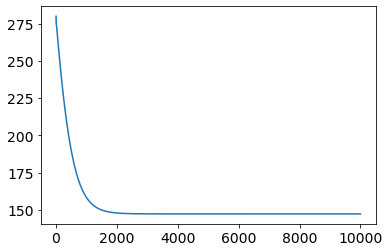

In [14]:
timeseries['atmpco2'].plot()

<AxesSubplot:>

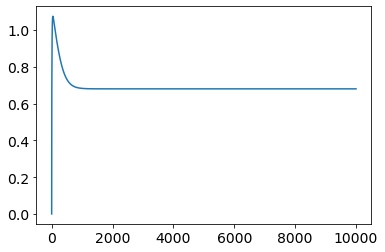

In [15]:
timeseries['exportna'].plot()

In [11]:
timeseries

,time,tso,tna,tdo,sso,sna,sdo,cso,cna,cdo,...,exportso,exportna,exportdo,lim,pstar,pco2so,pco2na,pco2do,atmpco2,exp
0,0.1,20.0,10.0,4.0,35.5,35.5,34.5,2000.000000,2000.000000,2220.000000,...,0.000000,0.000000,0.000000,0.0,0.800000,247.104115,151.714632,506.052379,280.000000,0.000000
1,100.0,20.0,10.0,4.0,35.5,35.5,34.5,2021.817047,2070.725357,2220.503142,...,0.152839,1.164013,-1.316852,222.0,0.091993,283.602457,241.797850,508.255849,271.407406,1.316852
2,200.0,20.0,10.0,4.0,35.5,35.5,34.5,2015.197201,2064.423878,2221.673760,...,0.278607,1.170604,-1.449211,223.0,0.151135,273.802169,233.042535,514.195576,262.615495,1.449211
3,300.0,20.0,10.0,4.0,35.5,35.5,34.5,2007.119328,2056.209034,2223.181730,...,0.379743,1.175909,-1.555652,223.0,0.198795,262.104701,221.859675,521.991049,251.286811,1.555652
4,400.0,20.0,10.0,4.0,35.5,35.5,34.5,1998.523249,2047.082129,2224.784203,...,0.458355,1.180036,-1.638391,223.0,0.235877,250.167379,210.061375,530.444289,239.271830,1.638391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,99600.0,20.0,10.0,4.0,35.5,35.5,34.5,1954.533443,1995.525096,2232.336209,...,0.659621,1.190617,-1.850238,223.0,0.331066,197.598334,155.686036,572.670622,183.220643,1.850238
997,99700.0,20.0,10.0,4.0,35.5,35.5,34.5,1954.533443,1995.525096,2232.336209,...,0.659621,1.190617,-1.850238,223.0,0.331066,197.598334,155.686036,572.670622,183.220643,1.850238
998,99800.0,20.0,10.0,4.0,35.5,35.5,34.5,1954.533443,1995.525096,2232.336209,...,0.659621,1.190617,-1.850238,223.0,0.331066,197.598334,155.686036,572.670622,183.220643,1.850238
999,99900.0,20.0,10.0,4.0,35.5,35.5,34.5,1954.533443,1995.525096,2232.336209,...,0.659621,1.190617,-1.850238,223.0,0.331066,197.598334,155.686036,572.670622,183.220643,1.850238
